Kaggle Getting Started prediction Competition: Digit Recognizer:
https://www.kaggle.com/c/digit-recognizer/overview

In [1]:
import torch
import numpy as np
import pandas as pd


train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train_size, val_size = 35700, 6300

train_tensor, val_tensor = torch.split(torch.tensor(train.values).reshape(42000, 785), [train_size, val_size])

train_labels = train_tensor[:,0]
train_data = train_tensor[:,1:].reshape(train_size, 28, 28)
train_data = train_data.unsqueeze(1).float()

val_labels = val_tensor[:,0]
val_data = val_tensor[:,1:].reshape(val_size, 28, 28)
val_data = val_data.unsqueeze(1).float()

test_data = torch.tensor(test.values).reshape(28000, 28, 28)
test_data = test_data.unsqueeze(1).float()


print(train_data.shape, val_data.shape, test_data.shape, sep='\n')

torch.Size([35700, 1, 28, 28])
torch.Size([6300, 1, 28, 28])
torch.Size([28000, 1, 28, 28])


In [13]:
from torchvision import transforms
import PIL


class CustomTensorDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

        
    def __getitem__(self, index):
        x = self.data[index]
        if self.transform:
            x = self.transform(x)

        y = self.labels[index]

        return x, y

    
    def __len__(self):
        return len(self.data)


train_transform = transforms.Compose([
    transforms.Lambda(lambda x: x / 255),
    transforms.ToPILImage(),
    transforms.RandomAffine((-10., 10.), translate=(0.1, 0.1), scale=(0.9, 1.1), shear=None,
                                        resample=PIL.Image.NEAREST, fillcolor=0),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x * 255)
])

batch_size = 100

train_dataset = CustomTensorDataset(train_data, train_labels, transform=train_transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

val_dataset = CustomTensorDataset(val_data, val_labels, transform=None)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


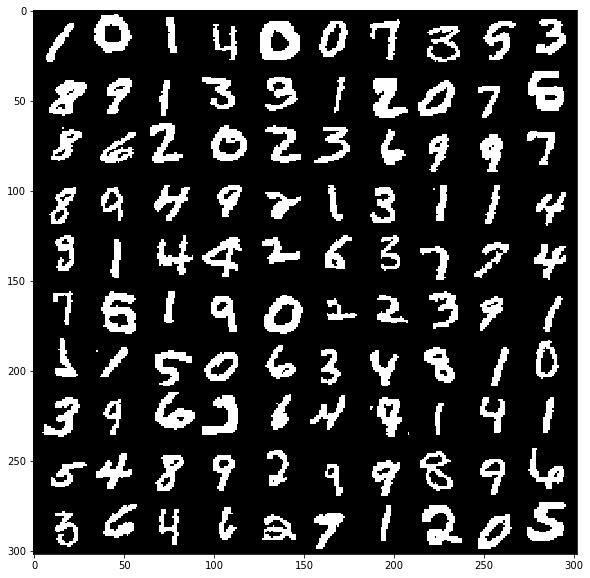

In [14]:
import matplotlib.pyplot as plt
import torchvision

    
for i, data in enumerate(train_dataloader):
    x, y = data
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(torchvision.utils.make_grid(x, 10).numpy(), (1, 2, 0)))
    plt.show()
    break 

In [15]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()      

        self.conv_block_1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=0),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(inplace=True),
            
            torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=0),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(inplace=True),
            
            torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, stride=2, padding=2),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(inplace=True),
            
            torch.nn.Dropout2d(p=0.4)
        )
        
        self.conv_block_2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=0),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(inplace=True),
            
            torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=0),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(inplace=True),
            
            torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=2, padding=2),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(inplace=True),
            
            torch.nn.Dropout2d(p=0.4),
            
            torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, padding=0),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(inplace=True)
        )

        self.fc_block = torch.nn.Sequential(
            torch.nn.Dropout(p=0.4),
            torch.nn.Linear(128, 10)
        )
    
    
    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc_block(x)
        return x
    
    
model = LeNet5()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Device:', device)
model = model.to(device)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)


val_data = val_data.to(device)
val_labels = val_labels.to(device)
test_data = test_data.to(device)

Device: cuda:0


In [16]:
import time
import copy


def train_model(model, loss, optimizer, scheduler=None, epoch_number=10):
    history = {'Val' : {'Loss' : [], 'Acc' : []}, 'Train' : {'Loss' : [], 'Acc' : []}}
    best_acc = 0.
    best_epoch = 0
    best_model_state = copy.deepcopy(model.state_dict())
    
    since = time.time()

    for epoch in range(epoch_number):
        print('Epoch  {}  of  {} :'.format(epoch + 1, epoch_number))
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()
                        if scheduler != None:
                            scheduler.step()
                
                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            
            if phase == 'train':
                train_loss = epoch_loss
                train_acc = epoch_acc
            else:
                val_loss = epoch_loss
                val_acc = epoch_acc
                if val_acc > best_acc:
                    best_acc = val_acc
                    best_epoch = epoch
                    best_model_state = copy.deepcopy(model.state_dict())
                    

        print('Validtion:    Loss:  {:4f}   Acc:  {:4f}'.format(val_loss, val_acc))
        print('Train:        Loss:  {:4f}   Acc:  {:4f}'.format(train_loss, train_acc))
        print()
        print('-' * 25)
        print()

        history['Val']['Loss'].append(val_loss)
        history['Val']['Acc'].append(val_acc)
        history['Train']['Loss'].append(train_loss)
        history['Train']['Acc'].append(train_acc)
    
    time_elapsed = time.time() - since
    print('\n')
    print('Training time:  {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc:   {:4f}'.format(best_acc))
    print('Best epoch:     {:d}'.format(best_epoch))
    
    return model, best_model_state, history

In [17]:
model, best_model_state, history = train_model(model, loss, optimizer, scheduler=None, epoch_number=20)

Epoch  1  of  20 :
Validtion:    Loss:  0.060467   Acc:  0.983016
Train:        Loss:  0.575569   Acc:  0.829524

-------------------------

Epoch  2  of  20 :
Validtion:    Loss:  0.039107   Acc:  0.987619
Train:        Loss:  0.173060   Acc:  0.949805

-------------------------

Epoch  3  of  20 :
Validtion:    Loss:  0.035060   Acc:  0.988730
Train:        Loss:  0.138009   Acc:  0.960197

-------------------------

Epoch  4  of  20 :
Validtion:    Loss:  0.031337   Acc:  0.990476
Train:        Loss:  0.112518   Acc:  0.966275

-------------------------

Epoch  5  of  20 :
Validtion:    Loss:  0.029992   Acc:  0.989365
Train:        Loss:  0.099836   Acc:  0.969636

-------------------------

Epoch  6  of  20 :
Validtion:    Loss:  0.024659   Acc:  0.992540
Train:        Loss:  0.089251   Acc:  0.972578

-------------------------

Epoch  7  of  20 :
Validtion:    Loss:  0.024792   Acc:  0.991905
Train:        Loss:  0.084514   Acc:  0.974958

-------------------------

Epoch  8  of 

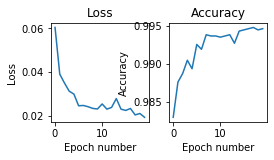

In [18]:
import matplotlib.pyplot as plt

plt.subplot(235)

plt.xlabel('Epoch number')
plt.ylabel('Loss')
plt.title('Loss')
plt.plot(history['Val']['Loss'], label = 'val_loss')


plt.subplot(236)

plt.xlabel('Epoch number')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.plot(history['Val']['Acc'], label = 'val_accuracy')

plt.show()

In [19]:
from tqdm import tqdm


model.eval()
test_preds = torch.LongTensor()

for start_index in tqdm(range(0, len(test_data), batch_size)):

    data_batch = test_data[start_index:start_index + batch_size].to(device)
    
    batch_preds = model(data_batch)
    test_preds = torch.cat((test_preds, batch_preds.cpu().data.max(1, keepdim=True)[1]), dim=0)

100%|███████████████████████████████████████| 280/280 [00:01<00:00, 143.66it/s]


In [20]:
submission_df = pd.DataFrame.from_dict({'ImageId': np.arange(1, len(test_data) + 1), 'Label': test_preds.numpy()[:,0]})

submission_df.set_index('ImageId', inplace=True)

submission_df.to_csv('submission.csv')

In [21]:
submission_df.head()

,Label
ImageId,
1,2
2,0
3,9
4,0
5,3
